# CNNs to predict optical Q
Conduct hyperparameter search and train CNN.  Evaluate the importance of dropout for our application.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import keras
from tensorflow.python.framework import ops
from utils import *
import json
from datetime import datetime
import os

In [2]:
# data_path = r"Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat"
# data_path = r"Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\extracted_data_20241125.mat"
data_path = r"Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\extracted_data_20241201.mat"


mechFreq, optFreq, mechQ, optQ, paramsMat = load_data(data_path)

paramsShape = np.shape(paramsMat)[:-1]
num_examples = np.shape(paramsMat)[-1]
optQ_linearized = np.log10(optQ)

paramsMat_transposed = tf.transpose(paramsMat, perm = [3, 0, 1, 2])

print("shape of paramsMat_transposed: \t", np.shape(paramsMat_transposed))
print("shape of optQ: \t", np.shape(optQ))
print("number of training examples: \t", num_examples)

Loading data from:  Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\extracted_data_20241201.mat 

shape of paramsMat_transposed: 	 (1233, 11, 18, 3)
shape of optQ: 	 (1233, 1)
number of training examples: 	 1233


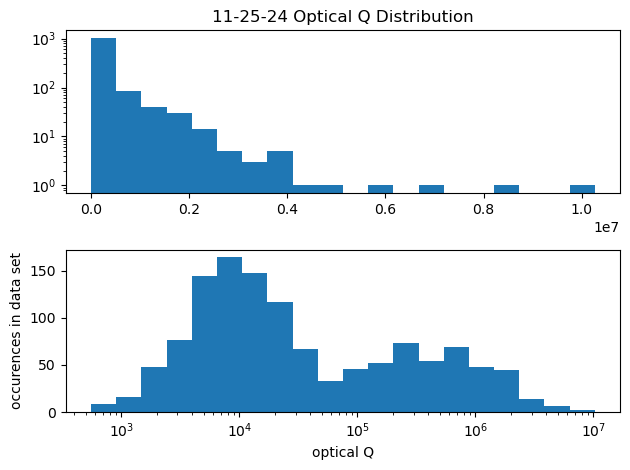

In [3]:
# looking at the data a bit:

x = optQ
# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=20)
plt.yscale('log')
plt.title("11-25-24 Optical Q Distribution")

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.xlabel("optical Q")
plt.ylabel('occurences in data set')
plt.tight_layout()
plt.savefig('optical_Q_dist_2.png', dpi = 400)

Split the data into train and test sets using tensorflow. Because optical Q is generally sampled logrithmically, to train with a linear activation in the last layer we should take the log of the optical Q data before giving it to the model.

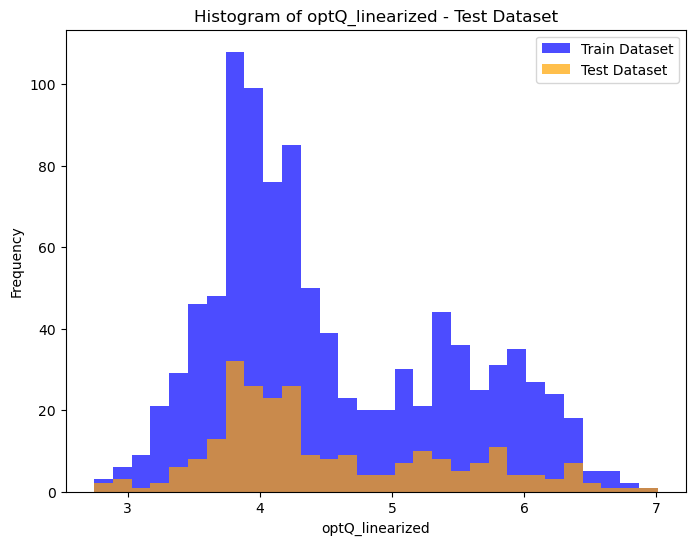

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((paramsMat_transposed, optQ_linearized))

# Shuffle and split the dataset
train_size = int(0.8 * num_examples)
shuffled_data = dataset.shuffle(buffer_size=num_examples)
train_dataset = shuffled_data.take(train_size)
test_dataset = shuffled_data.skip(train_size)


## let's actually look at our data breakup
show_train_test_dist(train_dataset, test_dataset)

# let's 
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Define the model

In [93]:
# define the model using the functional API structure rather than teh sequential structure in order to make it more flexible in the future.

def CNN_model(input_shape, kernel_size = [6, 2], pool_size = [8, 4], FC_nodes = [10]):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Arguments:
    input_img -- input dataset, of shape (input_shape)
    kernel_size -- list of kernel sizes for each Conv2D step
    pool_size -- list of pool sizes for each MaxPool2D step

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)

    Z1 = tfl.Conv2D(filters = 8, kernel_size = (kernel_size[0], kernel_size[0]), strides = 1, padding = 'same')(input_img)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size = (pool_size[0], pool_size[0]), strides = 2, padding = 'same')(A1)
    
    Z2 = tfl.Conv2D(filters = 16, kernel_size = (kernel_size[1], kernel_size[1]), strides = 1, padding = 'same')(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size = (pool_size[1], pool_size[1]), strides = 1, padding = 'same')(A2)
    
    F = tfl.Flatten()(P2)

    A3 = tfl.Dense(FC_nodes[0], activation = 'relu')(F)

    output = tfl.Dense(1)(A3)
    
    model = tf.keras.Model(inputs=input_img, outputs=output)
    return model

In [94]:
conv_model = CNN_model(paramsShape)
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
conv_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])

conv_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 11, 18, 8)           │             872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_30 (ReLU)                      │ (None, 11, 18, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 6, 9, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 6, 9, 16)            │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_31 (ReLU)                      │ (None, 6, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 6, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 864)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           8,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,061 (39.30 KB)

 Trainable params: 10,061 (39.30 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 27.8792 - mse: 27.8792 - val_loss: 2.1449 - val_mse: 2.1449
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7996 - mse: 1.7996 - val_loss: 1.0429 - val_mse: 1.0429
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0881 - mse: 1.0881 - val_loss: 0.9598 - val_mse: 0.9598
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1950 - mse: 1.1950 - val_loss: 1.2035 - val_mse: 1.2035
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1249 - mse: 1.1249 - val_loss: 1.0389 - val_mse: 1.0389
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1777 - mse: 1.1777 - val_loss: 1.0427 - val_mse: 1.0427
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9418 - mse: 0.9418 - val_loss: 1.1704 - val_mse: 1.1704
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9941 - mse: 0.9941 - val_loss: 0.9707 - val_mse: 0.9707
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0

In [67]:
conv_model.evaluate(test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4368 - mse: 0.4368


[0.40938955545425415, 0.40938955545425415]

Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\Linus\AppData\Local\Temp\ipykernel_33724\747123822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\Linus\AppData\Local\Temp\ipykernel_33724\747123822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

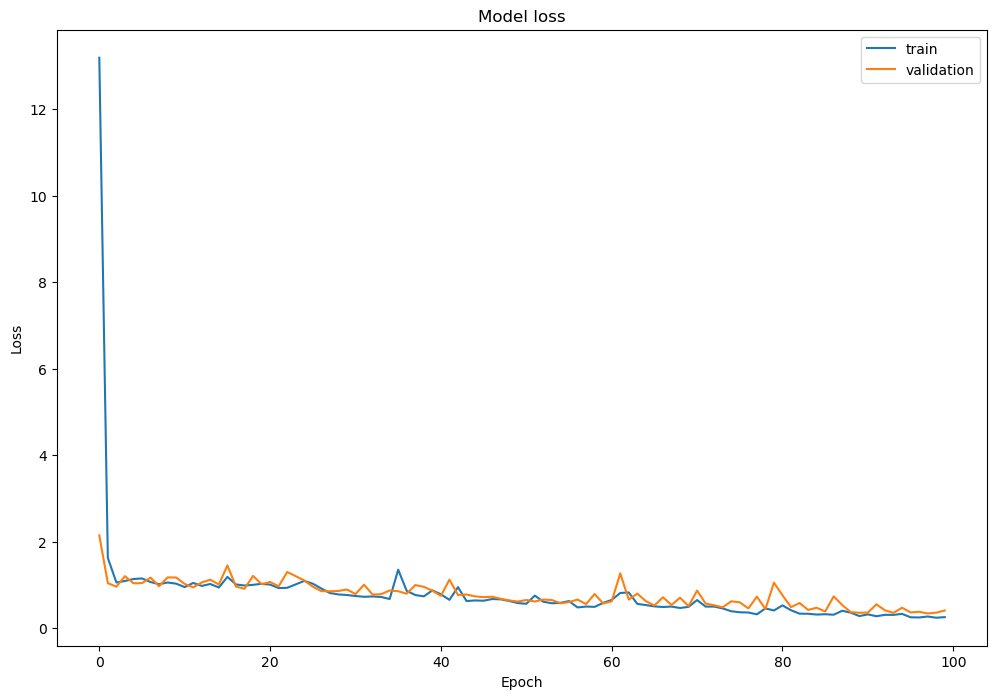

In [68]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_acc[['mse','val_mse']]
df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
# df_mse.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='MSE')

With a trained model in hand it might be nice to see individual examples of how good it is at predicting...

In [69]:
train_numbers = np.arange(10)
for train_number in train_numbers:
    test_iterator = iter(test_dataset)
    
    # Get a single batch (you can also use next(test_iterator) for just one item in the batch)
    batch_X, batch_Y = next(test_iterator)
    
    # Extract a single input and label pair from the batch
    # For example, take the first item from the batch
    single_input = batch_X[train_number].numpy()  # Convert to NumPy array
    single_label = batch_Y[train_number].numpy()  # Convert to NumPy array
    
    single_input =  np.expand_dims(single_input, axis=0) 
    
    prediction = conv_model.predict(single_input)
    
    print("predicted Q = {}".format(np.exp(prediction)))
    print("true Q = {}".format(np.exp(single_label)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
predicted Q = [[2113.62]]
true Q = [1764.473252]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[6315.2036]]
true Q = [10275.52294081]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[1875.7639]]
true Q = [3040.12035094]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[4212.159]]
true Q = [12165.39992799]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
predicted Q = [[520.87714]]
true Q = [900.82855068]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[8942.716]]
true Q = [8187.85774313]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[12601.296]]
true Q = [24255.90580533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[26304.266]]
true Q = [10110.06770586]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[12526.242]]
true Q = [17853.10393943]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
predicted Q = [[4684.145]]
true Q = [5647.03080601]


Seems like the model is having a hard time with large Q modes and low Q modes.  Need to think about good ways to give these outliers appropriate weight. ie. model is high bias currently.  however, gets the MSE down below 1 so we are consistently within an order of magnitude ~ this is sort of good.

## parametrizing the model for a random hyperparam search

In [25]:
def hyper_param_search(kernel_sizes, filters, pool_sizes, FC_nodes, lr, verbose = 2):
    """
    takes hyperparameters as input, then initializes and trains a model.
    _____________________________________________________________________
    Inputs:
        kernel_sizes - the kernel sizes for each convolutional layer
        filters - the number of filters used for each convolutional layer
        pool_size - the pool size for max pool operations between convolutions
        FC_node - the number of nodes in each dense layer of the model
        lr - the learning rate for the adam optimizer
    Outputs:
        performance - the performance of the trained model on the dev dataset
    """

    def CNN_model(input_shape, kernel_sizes = [6, 2], filters = [8, 16], pool_sizes = [8, 4], FC_nodes = [10]):
        """
        Implements the forward propagation for the model:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
        Arguments:
        input_img -- input dataset, of shape (input_shape)
        kernel_size -- list of kernel sizes for each Conv2D step
        pool_size -- list of pool sizes for each MaxPool2D step
    
        Returns:
        model -- TF Keras model (object containing the information for the entire training process) 
        """
    
        input_img = tf.keras.Input(shape=input_shape)
    
        P = input_img
        
        for kernel_size, num_filters, pool_size in zip(kernel_sizes, filters, pool_sizes):
            Z = tfl.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size), strides = 1, padding = 'same')(P)
            A = tfl.ReLU()(Z)
            P = tfl.MaxPool2D(pool_size = (pool_size, pool_size), strides = 2, padding = 'same')(A)
        
        F = tfl.Flatten()(P)
        A = F

        for node in FC_nodes:
            A = tfl.Dense(node, activation = 'relu')(A)
    
        output = tfl.Dense(1)(A)
        
        model = tf.keras.Model(inputs=input_img, outputs=output)
        return model
    
    conv_model = CNN_model(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes)
    optimizer = keras.optimizers.Adam(learning_rate = lr)
    conv_model.compile(optimizer=optimizer,
                      loss='mse',
                      metrics =['mse'])

    history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset, verbose = verbose)
    performance = conv_model.evaluate(test_dataset)
    return performance

In [26]:
def gen_random_hyperparams():
    '''
    generates hyperparameters to feed to the parameterized CNN model
        randomly chooses a number of convolutional + maxpool blocks between 1 and 6
        randomly selects set of conv kernel sizes, max pool sizes, and conv filter numbers
        randomly chooses number of dense layers between 1 and 4
        randomly chooses number of nodes in each dense layer
        randomly selects a learning rate on a log scale in the range 1e-1 to 1e-5

    The parameters are sorted such that the model gets increasingly more channels, the mask for conv and maxpool shrinks
    and the fully connected layers go to fewer and fewer nodes moving from input to output of the model.
    '''
    # number of conv + pool layers there will be, between 1 and 6
    num_conv_itters = np.random.randint(1, 6)

    # create list of random integers for the kernel sizes, pool sizes, and num_filers.  The filter numbers should increase
    # while the kernel sizes and pool sizes should decrease.
    kernel_sizes = [np.random.randint(1, 11) for _ in range(num_conv_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    kernel_sizes = sorted(kernel_sizes, reverse=True)

    pool_sizes = [np.random.randint(1, 11) for _ in range(num_conv_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    pool_sizes = sorted(pool_sizes, reverse=True)

    filters = [np.random.randint(1, 25) for _ in range(num_conv_itters)] # the filters should be sorted starting with fewer filters and going to more
    filters = sorted(filters, reverse=False)

    num_dense_itters = np.random.randint(1, 4)
    FC_nodes = [2**np.random.randint(1, 8) for _ in range(num_dense_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    FC_nodes = sorted(FC_nodes, reverse=True)

    # randomly generate the learning rate on a log scale
    rng = 4 # range of exponents
    center = 3 # center of distribution
    lr = 10**-(np.random.rand()*rng + (center-rng/2))

    return kernel_sizes, filters, pool_sizes, FC_nodes, lr



# check that this works once.
performance = hyper_param_search(*gen_random_hyperparams())
print(performance)

Epoch 1/100
31/31 - 1s - 31ms/step - loss: 12.1238 - mse: 12.1238 - val_loss: 1.5907 - val_mse: 1.5907
Epoch 2/100
31/31 - 0s - 4ms/step - loss: 1.1039 - mse: 1.1039 - val_loss: 0.9346 - val_mse: 0.9346
Epoch 3/100
31/31 - 0s - 3ms/step - loss: 0.8925 - mse: 0.8925 - val_loss: 0.8788 - val_mse: 0.8788
Epoch 4/100
31/31 - 0s - 3ms/step - loss: 0.8364 - mse: 0.8364 - val_loss: 0.8620 - val_mse: 0.8620
Epoch 5/100
31/31 - 0s - 3ms/step - loss: 0.8470 - mse: 0.8470 - val_loss: 0.8552 - val_mse: 0.8552
Epoch 6/100
31/31 - 0s - 3ms/step - loss: 0.8407 - mse: 0.8407 - val_loss: 0.8671 - val_mse: 0.8671
Epoch 7/100
31/31 - 0s - 3ms/step - loss: 0.8456 - mse: 0.8456 - val_loss: 0.8988 - val_mse: 0.8988
Epoch 8/100
31/31 - 0s - 3ms/step - loss: 0.8299 - mse: 0.8299 - val_loss: 0.7749 - val_mse: 0.7749
Epoch 9/100
31/31 - 0s - 3ms/step - loss: 0.8339 - mse: 0.8339 - val_loss: 0.9263 - val_mse: 0.9263
Epoch 10/100
31/31 - 0s - 3ms/step - loss: 0.8384 - mse: 0.8384 - val_loss: 0.8556 - val_mse: 0.8

The below cell crashed the window because my computer ran out of memory.  There must be a way to close the model after running it so that it doesn't continue to eat memory.  The dictionary could also have gotten too big, but this seems highly improbable given python's ability to store large datasets.

In [27]:
def update_hyperparams(hyperparams, params):
    '''
    adds row containing 'params' to the hyperparams dictionary

    params - tuple of form (kernel_sizes, filters, pool_sizes, FC_nodes, lr)
    '''
    for val, key in zip(params, hyperparams.keys()):
        hyperparams[key].append(val)

savepath = 'CNN_Optical_Q_hyperparams_{}.json'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))


hyperparams = {"kernel_sizes":[], "filters":[], "pool_sizes":[], "FC_nodes":[], "lr":[], "performance":[]}
for i in range(20):
    print(f'starting parameter combination {i}')
    params = gen_random_hyperparams()
    performance = hyper_param_search(*params, verbose = 0)
    params = list(params)
    params.append(performance)
    print("params: ", params, "\n")
    update_hyperparams(hyperparams, params)
    write_json(hyperparams, savepath)

starting parameter combination 0
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.6644 - mse: 14.6644
params:  [[9, 7, 6, 1], [4, 10, 16, 22], [9, 4, 2, 2], [4, 2], 0.0002579476269334547, [14.403124809265137, 14.403124809265137]] 

Writing data to:  CNN_Optical_Q_hyperparams_20241201-210005.json
starting parameter combination 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9701 - mse: 0.9701
params:  [[9, 7, 4, 1], [5, 5, 7, 24], [10, 7, 6, 2], [32, 16], 0.07695672491126856, [0.9765076637268066, 0.9765076637268066]] 

Writing data to:  CNN_Optical_Q_hyperparams_20241201-210005.json
starting parameter combination 2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8675 - mse: 0.8675
params:  [[10, 6, 1], [1, 4, 20], [10, 9, 6], [32, 8], 4.8898738121608965e-05, [0.8854547739028931, 0.8854547739028931]] 

Writing data to:  CNN_Optical_Q_hyperparams_20241201-210005.json
starting parameter combination 3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.8160 - mse: 12.8160
params:  [[5, 5, 2, 1],

In [55]:
path = "CNN_Optical_Q_hyperparams_20241125-234124.json"

loaded_data = read_json(path)

print("Loaded data:", pd.DataFrame(loaded_data))
df = pd.DataFrame(loaded_data)
df.to_csv(path.split()[0] + '.csv')

Loaded data:          kernel_sizes              filters        pool_sizes      FC_nodes  \
0    [10, 8, 4, 1, 1]   [7, 7, 18, 19, 21]  [10, 8, 4, 3, 1]       [64, 2]   
1        [7, 6, 5, 1]      [8, 19, 19, 21]     [10, 8, 6, 2]     [2, 2, 2]   
2          [10, 5, 2]         [14, 19, 23]         [9, 8, 4]         [128]   
3     [8, 8, 7, 4, 2]  [4, 15, 17, 19, 20]   [9, 9, 8, 4, 1]    [16, 8, 4]   
4          [10, 3, 3]          [6, 15, 24]         [7, 7, 6]    [64, 8, 4]   
..                ...                  ...               ...           ...   
195               [5]                  [6]               [2]  [128, 16, 4]   
196        [10, 2, 1]         [12, 21, 23]        [10, 4, 1]     [8, 2, 2]   
197         [8, 6, 6]         [20, 22, 23]         [6, 6, 2]          [64]   
198      [9, 2, 2, 1]     [16, 16, 20, 23]      [8, 7, 4, 1]          [16]   
199     [10, 9, 7, 4]       [1, 8, 13, 21]      [8, 7, 7, 5]           [8]   

           lr                                 perf

# Hyperparmeter search with dropout

In [52]:
def hyper_param_search_dropout(kernel_sizes, filters, pool_sizes, FC_nodes, dropouts, lr, verbose = 2):
    """
    takes hyperparameters as input, then initializes and trains a model.
    _____________________________________________________________________
    Inputs:
        kernel_sizes - the kernel sizes for each convolutional layer
        filters - the number of filters used for each convolutional layer
        pool_size - the pool size for max pool operations between convolutions
        FC_node - the number of nodes in each dense layer of the model
        lr - the learning rate for the adam optimizer
    Outputs:
        performance - the performance of the trained model on the dev dataset
    """

    def CNN_model(input_shape, kernel_sizes = [6, 2], filters = [8, 16], pool_sizes = [8, 4], FC_nodes = [10]):
        """
        Implements the forward propagation for the model:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
        Arguments:
        input_img -- input dataset, of shape (input_shape)
        kernel_size -- list of kernel sizes for each Conv2D step
        pool_size -- list of pool sizes for each MaxPool2D step
    
        Returns:
        model -- TF Keras model (object containing the information for the entire training process) 
        """
    
        input_img = tf.keras.Input(shape=input_shape)
    
        P = input_img
        
        for kernel_size, num_filters, pool_size in zip(kernel_sizes, filters, pool_sizes):
            Z = tfl.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size), strides = 1, padding = 'same')(P)
            A = tfl.ReLU()(Z)
            P = tfl.MaxPool2D(pool_size = (pool_size, pool_size), strides = 2, padding = 'same')(A)
        
        F = tfl.Flatten()(P)
        A = F

        for node, dropout in zip(FC_nodes, dropouts):
            A = tfl.Dense(node, activation = 'relu')(A)
            A = tfl.Dropout(rate = dropout)(A)
            
            
        output = tfl.Dense(1)(A)
        
        model = tf.keras.Model(inputs=input_img, outputs=output)
        return model
    
    conv_model = CNN_model(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes)
    optimizer = keras.optimizers.Adam(learning_rate = lr)
    conv_model.compile(optimizer=optimizer,
                      loss='mse',
                      metrics =['mse'])

    history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset, verbose = verbose)
    performance = conv_model.evaluate(test_dataset)
    return performance

In [58]:
def gen_random_hyperparams_dropout():
    '''
    generates hyperparameters to feed to the parameterized CNN model
        randomly chooses a number of convolutional + maxpool blocks between 1 and 6
        randomly selects set of conv kernel sizes, max pool sizes, and conv filter numbers
        randomly chooses number of dense layers between 1 and 4
        randomly chooses number of nodes in each dense layer
        randomly selects a learning rate on a log scale in the range 1e-1 to 1e-5

    The parameters are sorted such that the model gets increasingly more channels, the mask for conv and maxpool shrinks
    and the fully connected layers go to fewer and fewer nodes moving from input to output of the model.
    '''
    # number of conv + pool layers there will be, between 1 and 6
    num_conv_itters = np.random.randint(1, 6)

    # create list of random integers for the kernel sizes, pool sizes, and num_filers.  The filter numbers should increase
    # while the kernel sizes and pool sizes should decrease.
    kernel_sizes = [np.random.randint(1, 11) for _ in range(num_conv_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    kernel_sizes = sorted(kernel_sizes, reverse=True)

    pool_sizes = [np.random.randint(1, 11) for _ in range(num_conv_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    pool_sizes = sorted(pool_sizes, reverse=True)

    filters = [np.random.randint(1, 25) for _ in range(num_conv_itters)] # the filters should be sorted starting with fewer filters and going to more
    filters = sorted(filters, reverse=False)

    num_dense_itters = np.random.randint(1, 4)
    FC_nodes = [2**np.random.randint(1, 8) for _ in range(num_dense_itters)] # 11 is natural upper bound as this is the dimension of the input on one axis
    FC_nodes = sorted(FC_nodes, reverse=True)
    
    dropouts = list(10**(np.random.uniform(-4, -0.5, size = num_dense_itters)))

    # randomly generate the learning rate on a log scale
    rng = 4 # range of exponents
    center = 3 # center of distribution
    lr = 10**-(np.random.rand()*rng + (center-rng/2))

    return kernel_sizes, filters, pool_sizes, FC_nodes, dropouts, lr


# check that this works once.
params = gen_random_hyperparams_dropout()
print(params)
performance = hyper_param_search_dropout(*params, verbose = 0)
print(performance)

([6, 1], [11, 20], [9, 1], [32, 8], [0.001154702576481922, 0.04330288366189738], 2.5965535204790357e-05)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9028 - mse: 1.9028
[2.2659685611724854, 2.2659685611724854]


In [59]:
def update_hyperparams_dropout(hyperparams_dropout, params):
    '''
    adds row containing 'params' to the hyperparams_dropout dictionary

    params - tuple of form (kernel_sizes, filters, pool_sizes, FC_nodes, lr)
    '''
    for val, key in zip(params, hyperparams_dropout.keys()):
        hyperparams_dropout[key].append(val)

savepath = 'CNN_Optical_Q_hyperparams_dropout_{}.json'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))


hyperparams_dropout = {"kernel_sizes":[], "filters":[], "pool_sizes":[], "FC_nodes":[], "dropouts": [], "lr":[], "performance":[]}
for i in range(200):
    print(f'starting parameter combination {i}')
    params = gen_random_hyperparams_dropout()
    performance = hyper_param_search_dropout(*params, verbose = 0)
    params = list(params)
    params.append(performance)
    print("params: ", params, "\n")
    update_hyperparams_dropout(hyperparams_dropout, params)
    write_json(hyperparams_dropout, savepath)

starting parameter combination 0
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4923 - mse: 1.4923
params:  [[9, 1], [2, 22], [9, 8], [8], [0.0005645075954411018], 0.0025062714229451264, [1.7337000370025635, 1.7337000370025635]] 

Writing data to:  CNN_Optical_Q_hyperparams_dropout_20241126-092131.json
starting parameter combination 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2363 - mse: 0.2363
params:  [[10, 9, 9, 8, 4], [5, 13, 18, 19, 19], [10, 8, 7, 5, 2], [8, 2], [0.0031308458554176453, 0.00022984982726502942], 0.004838658726124077, [0.27787426114082336, 0.27787426114082336]] 

Writing data to:  CNN_Optical_Q_hyperparams_dropout_20241126-092131.json
starting parameter combination 2
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0910 - mse: 2.0910
params:  [[10, 6, 5], [10, 13, 21], [8, 5, 4], [32, 16, 4], [0.0009229302778709741, 0.10013989374955837, 0.007862429364886632], 0.0001406409996479899, [2.5045547485351562, 2.5045547485351562]] 

Writing data to:  CNN_Optical_Q_hyperp

In [28]:
path = "CNN_Optical_Q_hyperparams_20241201-210005.json"

loaded_data = read_json(path)

df = pd.DataFrame(loaded_data)
df.to_csv(path.split(".")[0] + '.csv')

## Define More Parametrized CNN
Used for manual tinkering with model parameters and later used for transfer learning.

In [9]:
def CNN_model(input_shape, kernel_sizes = [6, 2], filters = [8, 16], pool_sizes = [8, 4], FC_nodes = [10], lr = 0.01):
        """
        Implements the forward propagation for the model:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
        Arguments:
        input_img -- input dataset, of shape (input_shape)
        kernel_size -- list of kernel sizes for each Conv2D step
        pool_size -- list of pool sizes for each MaxPool2D step
    
        Returns:
        model -- TF Keras model (object containing the information for the entire training process) 
        """
    
        input_img = tf.keras.Input(shape=input_shape)
    
        P = input_img
        
        for kernel_size, num_filters, pool_size in zip(kernel_sizes, filters, pool_sizes):
            Z = tfl.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size), strides = 1, padding = 'same')(P)
            A = tfl.ReLU()(Z)
            P = tfl.MaxPool2D(pool_size = (pool_size, pool_size), strides = 2, padding = 'same')(A)
        
        F = tfl.Flatten()(P)
        A = F

        for node in FC_nodes:
            A = tfl.Dense(node, activation = 'relu')(F)
    
        output = tfl.Dense(1)(A)
        
        model = tf.keras.Model(inputs=input_img, outputs=output)
        optimizer = keras.optimizers.Adam(learning_rate = lr)
        model.compile(optimizer=optimizer,
                          loss='mse',
                          metrics =['mse'])
        return model

In [21]:
## train model with best performing parameters from the random search
## best performer from CNN_Optical_Q_hyperparams_20241112-212236.json
# kernel_sizes, filters, pool_sizes, FC_nodes, lr = [10, 10], [23, 24], [10, 2], [64], 0.0019715835257217303
# kernel_sizes, filters, pool_sizes, FC_nodes, lr = [9, 4, 4, 2],	[15, 22, 23, 23], [10, 6, 1, 1], [128, 128, 16], 0.0024823465484887066
kernel_sizes, filters, pool_sizes, FC_nodes, lr = [10, 5], [16, 24], [10, 1], [128, 64, 16], 0.0010438169495987548


conv_model = CNN_model(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes, lr)

history = conv_model.fit(train_dataset, epochs=500, validation_data=test_dataset)
performance = conv_model.evaluate(test_dataset)

# save the model weights for transfer learning or just bringing the model back to life later
model_name = "conv_model_{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))

weights_path = model_name + ".weights.h5"
conv_model.save_weights(weights_path)

model_path = model_name+".keras"
conv_model.save(model_path)

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7091 - mse: 7.7091 - val_loss: 0.7919 - val_mse: 0.7919
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9004 - mse: 0.9004 - val_loss: 1.0404 - val_mse: 1.0404
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8900 - mse: 0.8900 - val_loss: 0.8594 - val_mse: 0.8594
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8551 - mse: 0.8551 - val_loss: 0.8463 - val_mse: 0.8463
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8337 - mse: 0.8337 - val_loss: 0.8706 - val_mse: 0.8706
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8430 - mse: 0.8430 - val_loss: 0.8613 - val_mse: 0.8613
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8229 - mse: 0.8229 - val_loss: 0.8268 - val_mse: 0.8268
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8244 - mse: 0.8244 - val_loss: 0.7044 - val_mse: 0.7044
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.811

Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\Linus\AppData\Local\Temp\ipykernel_17312\2160677342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\Linus\AppData\Local\Temp\ipykernel_17312\2160677342.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)


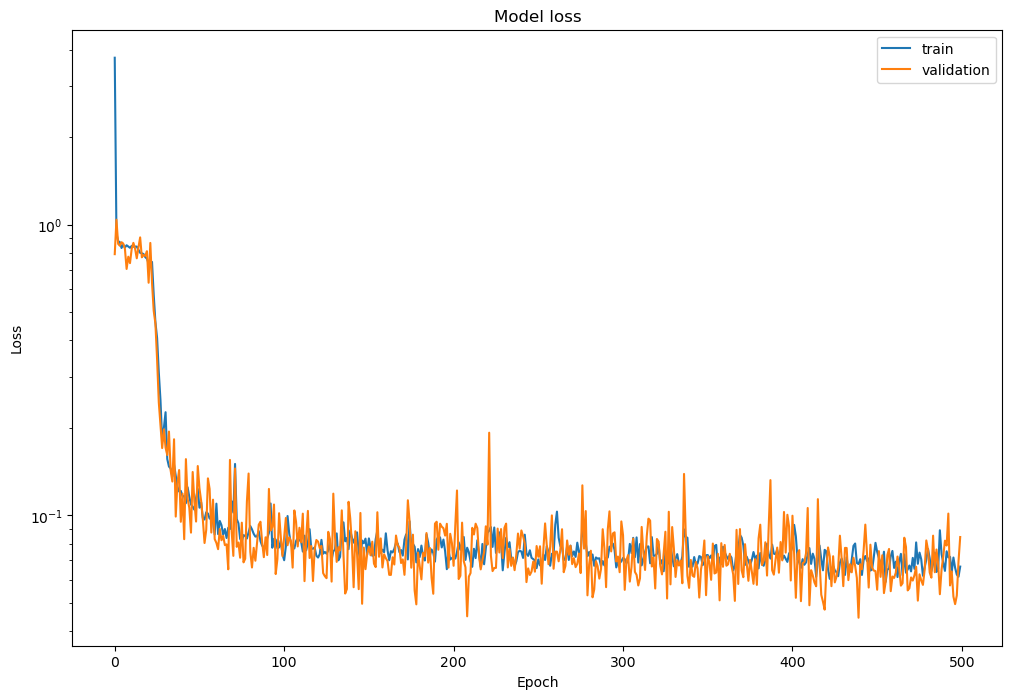

In [22]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_acc[['mse','val_mse']]
df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
plt.yscale('log')
fname = model_name  + "_training_hist.png"  #"training_hist_{}.png".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
plt.savefig(fname)

In [23]:
## look at some data of model predictions vs labels
conv_model = tf.keras.models.load_model(r"Z:\lwoodard\Courses\Deep Learning\BDTNet\optcial_Q_Net\{}.keras".format(model_name))
predictions = []
labels = []
example_numbers = np.arange(32)
for batch_number in [1,2,3, 4, 5]:
    predicted, true = show_predicted_Qs(example_numbers, batch_number, test_dataset, conv_model)
    predictions.append(predicted)
    labels.append(true)

# pd.DataFrame({"CNN_predicted":predictions, "CNN_labels":labels}).to_csv(r"prediction_true_data.csv")

predicted Q = 612651.252194366
true Q = 543324.9518234396

predicted Q = 602663.0933518736
true Q = 271137.7991438511

predicted Q = 13485.456310564234
true Q = 12165.399927987168

predicted Q = 72786.68893901796
true Q = 66854.1387792399

predicted Q = 12030.710358697841
true Q = 9467.068509941972

predicted Q = 13898.52314480118
true Q = 9599.975064473758

predicted Q = 5749.372244864198
true Q = 4407.815287401827

predicted Q = 7657.244986895415
true Q = 6331.730965844291

predicted Q = 11133.416984606863
true Q = 8222.143782096871

predicted Q = 538194.6648605134
true Q = 315854.96394199994

predicted Q = 1868.2203921487096
true Q = 1461.2901971094534

predicted Q = 528898.070407952
true Q = 268788.76752024976

predicted Q = 743012.2917018723
true Q = 1926823.48237385

predicted Q = 6384.472168252824
true Q = 5508.618315567692

predicted Q = 20922.306961227074
true Q = 15293.316641282028

predicted Q = 595374.5784454059
true Q = 627590.9685124032

predicted Q = 498365.98120910354
t

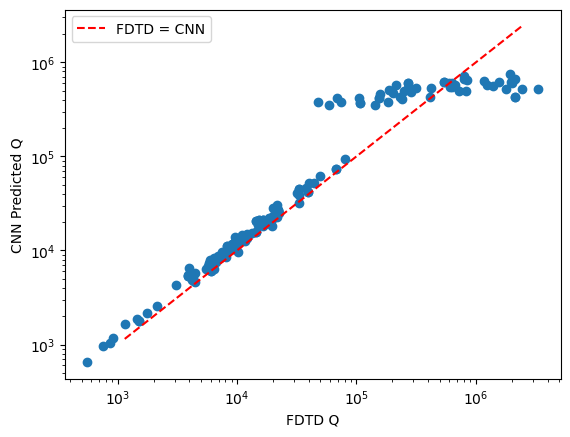

In [24]:
plt.scatter(labels, predictions)
plt.plot([min(labels[0]), max(labels[0])], [min(labels[0]), max(labels[0])], 'r--', label = "FDTD = CNN")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("FDTD Q")
plt.ylabel("CNN Predicted Q")
plt.legend()
fname = "model_prediction_" + model_name + ".png" #"model_prediciton_{}.png".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
plt.savefig(fname, dpi = 400, bbox_inches = 'tight')

In [48]:
performance = conv_model.evaluate(test_dataset)
print(performance)
# print('\n', np.array(labels[0]),  '\n\n', np.array(predictions[0]), '\n')
# ms = ((np.array(labels[0]) - np.array(predictions[0]))**2
rmse = (np.mean((np.log10(np.array(labels[0])) - np.log10(np.array(predictions[0])))**2))**0.5
print(10**rmse)
print(ms, mse, )

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0083 - mse: 0.0083
[0.010735058225691319, 0.010735058225691319]
1.19963779560134
[6.79366138e+06 1.06302649e+06 8.50726394e+05 4.42816377e+06
 1.49768367e+05 2.03315132e+03 1.34943441e+04 1.25448106e+05
 5.60346049e+05 1.54521244e+04 2.25524182e+04 1.35060208e+07
 5.08592428e+05 3.54238511e+06 1.48847204e+07 1.72370365e+06
 1.83632046e+06 1.01781078e+05 5.27120294e+06 4.40198536e+01
 1.00136176e+07 2.00101218e+04 2.76983069e+06 3.56461812e+06
 3.40567686e+07 8.34138778e+06 7.93888865e+03 1.64391906e+06
 1.35916354e+06 5.65404243e+05 3.85344240e+05 1.14426160e+07] 0.07905014011726974


## CNN with dropout
Taking best preforming network and adding dropout to the model to increase generalization.  With this model, seems that we can acuratly predict Q to one significant digit and most of the time to two significant digits.

In [54]:
def CNN_model_w_dropout(input_shape, kernel_sizes = [6, 2], filters = [8, 16], pool_sizes = [8, 4], FC_nodes = [10], lr = 0.01):
        """
        Implements the forward propagation for the model:
        CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
        Arguments:
        input_img -- input dataset, of shape (input_shape)
        kernel_size -- list of kernel sizes for each Conv2D step
        pool_size -- list of pool sizes for each MaxPool2D step
    
        Returns:
        model -- TF Keras model (object containing the information for the entire training process) 
        """
    
        input_img = tf.keras.Input(shape=input_shape)
    
        P = input_img
        
        for kernel_size, num_filters, pool_size in zip(kernel_sizes, filters, pool_sizes):
            Z = tfl.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size), strides = 1, padding = 'same')(P)
            A = tfl.ReLU()(Z)
            P = tfl.MaxPool2D(pool_size = (pool_size, pool_size), strides = 2, padding = 'same')(A)
        
        F = tfl.Flatten()(P)
        A = F

        drop_layer = 1
        for node in FC_nodes:
            A = tfl.Dense(node, activation = 'relu')(F)
            if drop_layer == 1:
                A = tfl.Dropout(rate = 0.01)(A)
            drop_layer += 1
    
        output = tfl.Dense(1)(A)
        
        model = tf.keras.Model(inputs=input_img, outputs=output)

        optimizer = keras.optimizers.Adam(learning_rate = lr)
        model.compile(optimizer=optimizer,
                      loss='mse',
                      metrics =['mse'])
    
        return model

In [55]:
## best performer from CNN_Optical_Q_hyperparams_20241112-212236.json
kernel_sizes, filters, pool_sizes, FC_nodes, lr = [10, 10], [23, 24], [10, 2], [64], 0.0019715835257217303 * 0.1

conv_model_w_dropout = CNN_model_w_dropout(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes, lr)

history = conv_model_w_dropout.fit(train_dataset, epochs=500, validation_data=test_dataset)
performance = conv_model_w_dropout.evaluate(test_dataset)

weights_path = "conv_model_w_dropout_{}.weights.h5".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
conv_model_w_dropout.save_weights(weights_path)

Epoch 1/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 7.1742 - mse: 7.1742 - val_loss: 0.2817 - val_mse: 0.2817
Epoch 2/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3014 - mse: 0.3014 - val_loss: 0.2226 - val_mse: 0.2226
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2094 - mse: 0.2094 - val_loss: 0.1877 - val_mse: 0.1877
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1891 - mse: 0.1891 - val_loss: 0.1898 - val_mse: 0.1898
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1771 - mse: 0.1771 - val_loss: 0.1856 - val_mse: 0.1856
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1840 - mse: 0.1840 - val_loss: 0.1840 - val_mse: 0.1840
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1846 - mse: 0.1846 - val_loss: 0.1885 - val_mse: 0.1885
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1906 - mse: 0.1906 - val_loss: 0.1894 - val_mse: 0.1894
Epoch 9/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - lo

predicted Q = 21586.24078981116
true Q = 18979.77548521513

predicted Q = 50274.3974563057
true Q = 49243.36569777605

predicted Q = 8788.739109675678
true Q = 7866.390805749998

predicted Q = 11271.39408547466
true Q = 9167.073822399114

predicted Q = 8343.272194594525
true Q = 8730.271376179075

predicted Q = 5751.14950796232
true Q = 5796.2399871982525

predicted Q = 5498.93368684981
true Q = 5382.768527921751

predicted Q = 1537.95972121021
true Q = 1183.7731801948214

predicted Q = 22529.360836091113
true Q = 21780.79818099506

predicted Q = 1262.8852687048832
true Q = 1138.5786945380885

predicted Q = 5864.663175938284
true Q = 6014.837801738155

predicted Q = 15983.185841067749
true Q = 12308.131995456542

predicted Q = 2078.1586056186493
true Q = 1365.0019411260212

predicted Q = 23678.743552716875
true Q = 21796.62105089476

predicted Q = 14672.879479707162
true Q = 18530.951582937116

predicted Q = 8119.948773627427
true Q = 6807.049823557001

predicted Q = 9113.202497535813


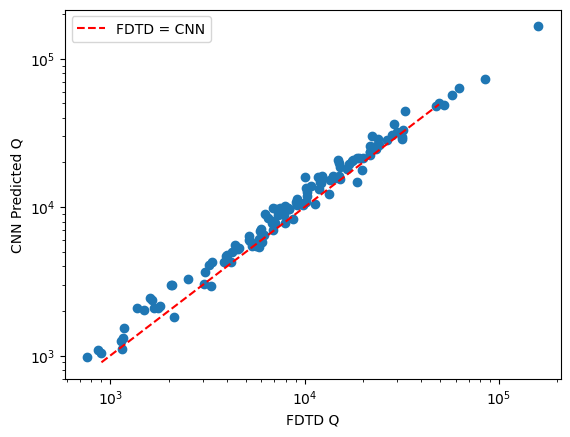

In [57]:
predictions = []
labels = []
example_numbers = np.arange(32)
for batch_number in [1,2,3, 4]:
    predicted, true = show_predicted_Qs(example_numbers, batch_number, test_dataset, conv_model)
    predictions.append(predicted)
    labels.append(true)

pd.DataFrame({"CNN_predicted":predictions, "CNN_labels":labels}).to_csv(r"prediction_true_data_CNN_w_dropout.csv")
plt.scatter(labels, predictions)
plt.plot([min(labels[0]), max(labels[0])], [min(labels[0]), max(labels[0])], 'r--', label = "FDTD = CNN")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("FDTD Q")
plt.ylabel("CNN Predicted Q")
plt.legend()
plt.savefig("model_prediciton_CNN_w_dropout.png", dpi = 400, bbox_inches = 'tight')

In [19]:
# retrieving a model
weights_path = r"conv_model_w_dropout_20241113-202125.weights.h5"

blank_model = CNN_model_w_dropout(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes, lr)
performace = blank_model.evaluate(test_dataset, verbose = 2)
# print(f'blank model performance {performace}')

loaded_model = CNN_model_w_dropout(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes, lr)
loaded_model.load_weights(weights_path)
performace =  loaded_model.evaluate(test_dataset, verbose = 2)
# print(f'loaded model performance {performace}')

6/6 - 0s - 18ms/step - loss: 16.1564 - mse: 16.1564
6/6 - 0s - 18ms/step - loss: 0.0099 - mse: 0.0099


Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\linus\AppData\Local\Temp\ipykernel_5544\2966314737.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\linus\AppData\Local\Temp\ipykernel_5544\2966314737.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)


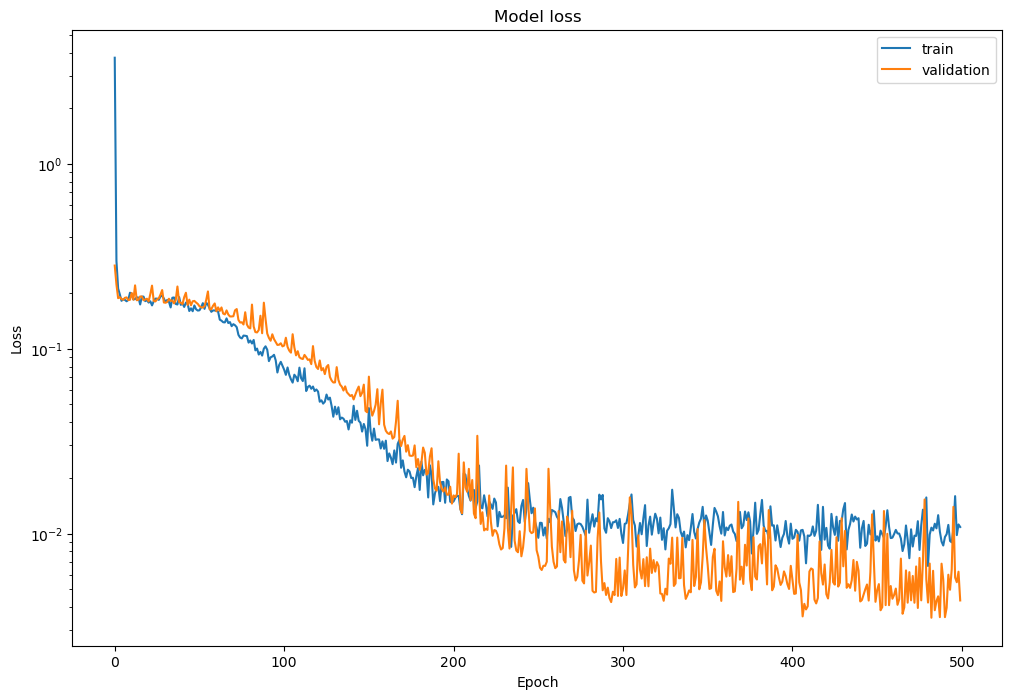

In [58]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_acc[['mse','val_mse']]
df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
plt.yscale('log')
plt.savefig("CNN_w_dropout_loss_history.png", dpi = 400,  bbox_inches = 'tight')

### Playing with the hyperparameters a bit

20241113-204719
6/6 - 0s - 2ms/step - loss: 0.0040 - mse: 0.0040


C:\Users\Linus\AppData\Local\Temp\ipykernel_15044\2390506639.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

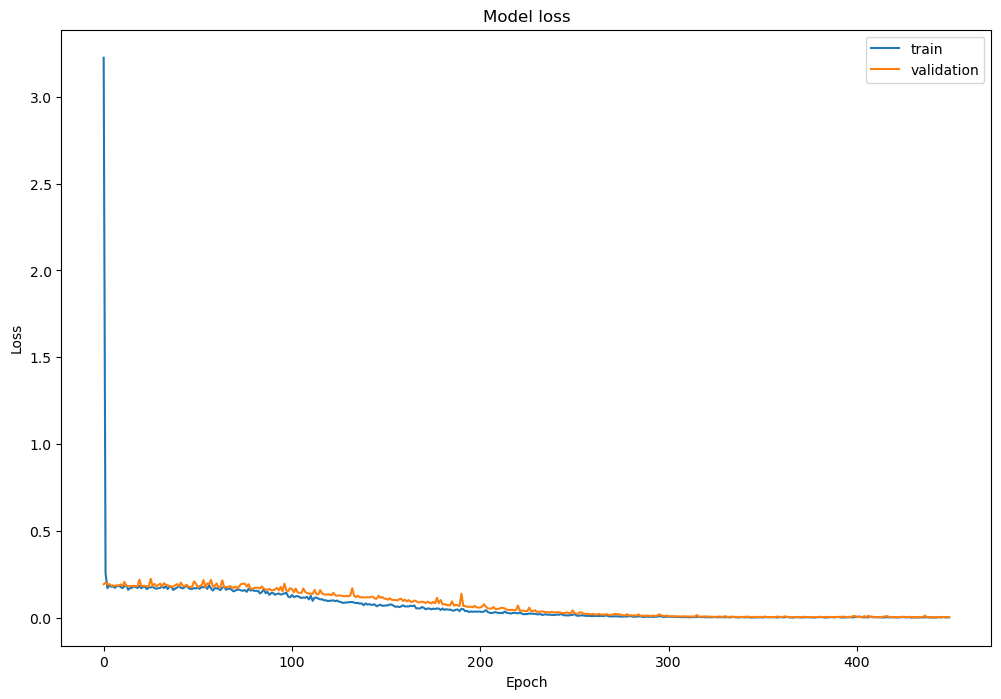

In [7]:
kernel_sizes, filters, pool_sizes, FC_nodes, lr = [8, 10], [15, 30], [10, 2], [64], 2e-4

conv_model = CNN_model(paramsShape, kernel_sizes, filters, pool_sizes, FC_nodes, lr)

history = conv_model.fit(train_dataset, epochs=450, validation_data=test_dataset, verbose = 0)
# save the model weights for transfer learning or just bringing the model back to life later -- don't rerun this cell
print(datetime.now().strftime("%Y%m%d-%H%M%S"))
weights_path = "conv_model_{}.weights.h5".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
conv_model.save_weights(weights_path) ### should be saving the whole model.

performance = conv_model.evaluate(test_dataset, verbose = 2)

df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
plt.yscale('log')